In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import grad, random, lax
import seaborn as sns

from jax import grad, jit, vmap
import numpy as np
from jax.example_libraries import optimizers

import optax

sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=10)

In [2]:
def linear_fn(params, X, gamma0):

    W0 = params[0]
    D = X.shape[0]
    h = W0 @ X / jnp.sqrt(D)
    for i, W in enumerate(params[1:-1]):
        h = 1/jnp.sqrt(W.shape[1]) * W @ h

    N = params[-1].shape[0]
    f = h.T @ params[-1] / (N * gamma0)
    return f

def linear_fn_reps(params, X, gamma0):

    W0 = params[0]
    D = X.shape[0]
    h = W0 @ X / jnp.sqrt(D)
    all_h = [ h.T @ h / h.shape[0] ]
    for i, W in enumerate(params[1:-1]):
        h = 1/jnp.sqrt(W.shape[1]) * W @ h
        all_h += [ h.T @ h / h.shape[0] ]
    N = params[-1].shape[0]
    f = h.T @ params[-1] / (N * gamma0)
    return f, all_h

def deep_linear(X, y, N, L, T, eta, gamma0, beta, seed = 0, center = False, sigma=0.0):

    M = X.shape[0]

    Ws = [random.normal(random.PRNGKey(seed), (N, M) )]

    for i in range(L-1):
        Ws += [ random.normal(random.PRNGKey(seed+i), ( N ,  N ) ) ]

    Ws += [ random.normal(random.PRNGKey(seed+L), (N,) ) ]

    P = y.shape[0]

    reg_loss_fn = jit(lambda p: 0.5 * N * gamma0**2 * jnp.sum( ( linear_fn(p, X, gamma0)  - y )**2 ) +  0.5/beta * optimizers.l2_norm(p)**2 )

    test_loss_fn = jit(lambda p: jnp.mean( ( linear_fn(p, X, gamma0)  - y )**2 ))

    solver = optax.noisy_sgd(learning_rate = eta , eta = 2.0 / beta / eta, gamma= 0.0)

    grad_fn = jit( grad(reg_loss_fn) )
    opt_state = solver.init( Ws )
    test_losses = []

    train_losses = []

    params = Ws.copy()

    H_avgs = []
    all_cs = []
    count = 0

    for t in range(T):

        train_losses += [ reg_loss_fn(params) ]
        test_losses += [test_loss_fn(params)]
        grads = grad_fn(params)
        updates, opt_state = solver.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)



        if t > 1000 and t % 10:
          _, Hs = linear_fn_reps(params, X, gamma)
          all_cs += [ [jnp.dot(y, H @ y) for H in Hs] ]
          if count == 0:
            H_avgs = [ H for H in Hs ]
          else:
            H_avgs = [  count / (count+1) * H_avgs[i] + 1/(count+1) * H for i, H in enumerate(Hs) ]

          count += 1

    return train_losses, test_losses, H_avgs, all_cs, params, Ws

In [3]:
D = 8
X = jnp.eye(D) * jnp.sqrt(D)
y = np.ones(D)
y[D//2:] = - np.ones(D//2)

y = y / jnp.sqrt(jnp.sum( y**2 ) )

N = 256
L = 16

eta = 0.0005
gamma = 4.0
beta = 10.0

T = 2500

train_losses, test_losses, H_avg, all_cs, params, Ws = deep_linear(X,y,N,L,T,eta,gamma,beta)

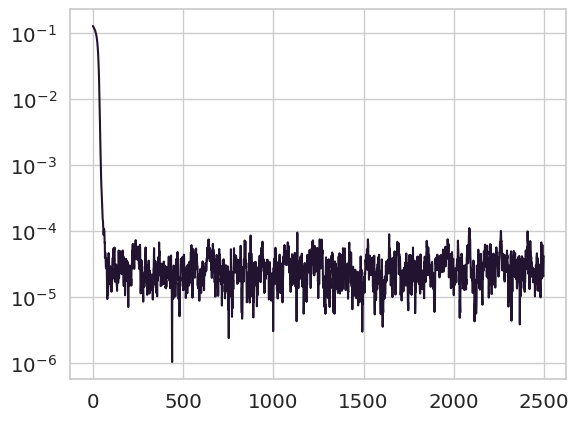

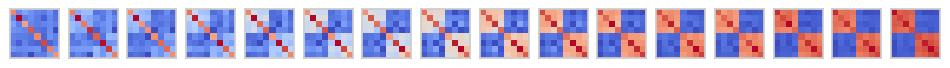

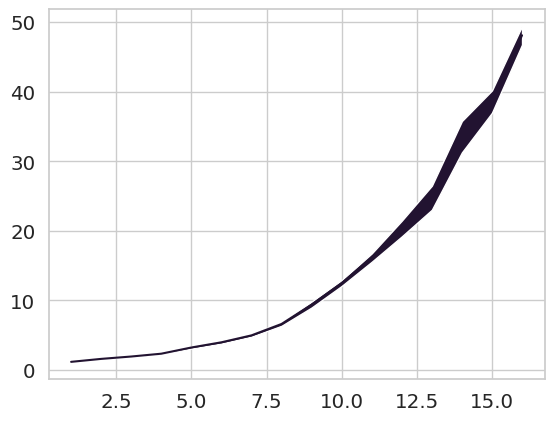

[ 1.1718669  1.596716   1.9375454  2.3432026  3.2335403  3.9811952
  4.976843   6.615467   9.398455  12.498083  16.158707  20.337147
 24.763126  33.538155  38.58419   48.112328 ]


In [4]:
plt.semilogy(test_losses)
plt.show()


plt.figure(figsize = (12,4))
for i, H in enumerate(H_avg):
  plt.subplot(1,L,i+1)
  plt.imshow( H , cmap = 'coolwarm')
  plt.xticks([])
  plt.yticks([])
plt.show()

plt.plot( jnp.arange(1,L+1),  jnp.array(all_cs).mean(axis=0) )
plt.fill_between(jnp.arange(1,L+1), jnp.array(all_cs).mean(axis=0) - jnp.array(all_cs).std(axis=0), jnp.array(all_cs).mean(axis=0) + jnp.array(all_cs).std(axis=0))
plt.show()

aligns = jnp.array([jnp.dot(y, H @ y) for H in H_avg])
print(aligns)

In [5]:
Nvals = [128, 256, 512, 1024, 2048]
all_losses = []
all_H = []
for i, N in enumerate(Nvals):
    print(N)
    train_losses, test_losses, Hs, all_cs, params, Ws = deep_linear(X,y,N,L,T,eta,gamma,beta)
    all_losses += [test_losses]
    #_, Hs = linear_fn_reps(params, X, gamma)
    all_H += [ Hs ]

128
256
512
1024
2048


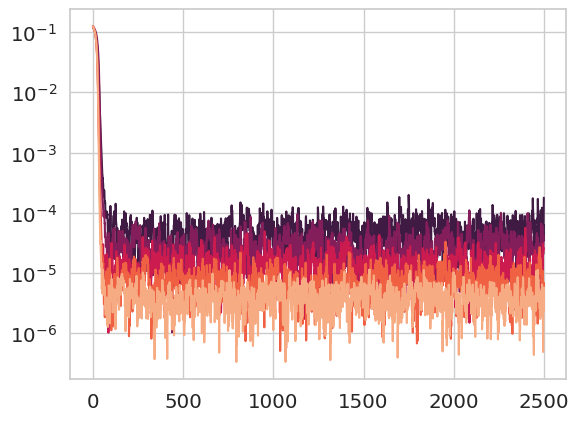

[ 0.12749681  0.161004    0.18928076  0.26639313  0.32268974  0.4433735
  0.5183804   0.71576214  0.99967986  1.8262782   3.1355317   4.8366036
  7.8276205   9.6317005  18.8289     31.372448  ]
[ 0.12946422  0.14691007  0.1779537   0.20961875  0.289607    0.372397
  0.5268775   0.8442364   1.5460353   2.5902615   4.226625    6.6120644
  9.752681   17.775488   23.465733   36.384148  ]
[ 0.14621812  0.1571841   0.1875734   0.22077355  0.2963473   0.38735342
  0.55551267  0.929222    1.4549055   2.3623292   3.8405747   6.7229915
 10.182131   19.548992   37.720284   56.046936  ]
[ 0.12977329  0.13321948  0.14499168  0.17503689  0.24000055  0.32246155
  0.45062646  0.7353169   1.2525042   2.1874843   3.703013    5.8626804
 10.584763   18.646002   31.552435   52.19757   ]
[ 0.13221595  0.14638695  0.16490068  0.21615145  0.28790092  0.3834939
  0.56800056  0.9345519   1.4907656   2.4860532   4.2754426   7.752368
 13.78643    22.99974    35.633343   58.39105   ]


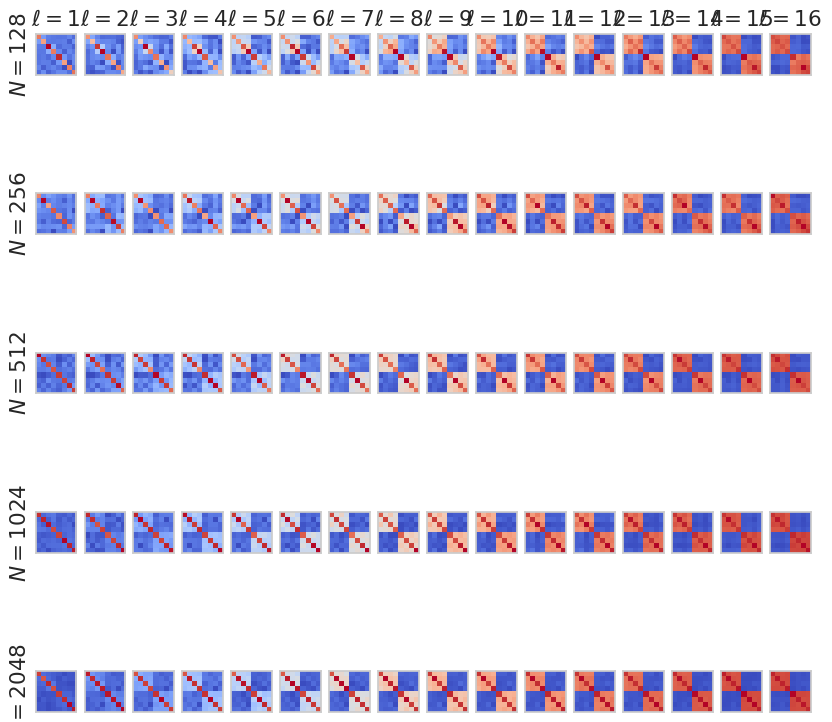

In [9]:
sns.set_palette("rocket", n_colors=len(Nvals))
for i, loss in enumerate(all_losses):
    plt.semilogy(loss)
plt.show()

plt.figure(figsize=(10,10))
for i, N in enumerate(Nvals):
    for j, H in enumerate(all_H[i]):
    plt.subplot( len(Nvals), L, i*L + j + 1 )
    if i == 0:
        plt.title(f'$\ell = {j+1}$')

    if j == 0:
        plt.ylabel(f'$N = {N}$')
    plt.imshow( H , cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])

    print( jnp.array([ jnp.mean(H**2) for H in all_H[i] ]) )

plt.show()


In [11]:
def solve_theory(gamma, beta, L):

    def func(c):
        chi = - gamma**2 * c / ( 1.0/beta + c )**2
        return c - (1.0 - chi)**L

    grad_fn = grad(func)

    c = 1 + L * gamma**2
    for t in range(50):
        c = c - 0.9 * func(c) /  grad_fn(c)


    chi = -  gamma**2 * c / ( 1.0/beta + c )**2

    overlaps = [ (1.0 - chi)**(k+1) for k in range(L) ]
    return overlaps, c

In [12]:
overlaps, c = solve_theory(gamma, beta, L)

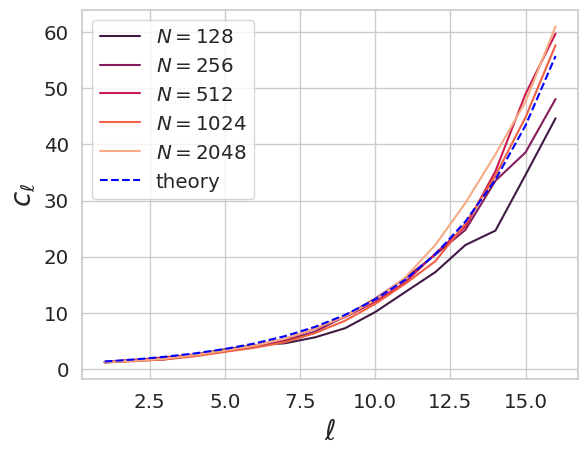

In [13]:
expt_overlaps = [[ jnp.dot(y, H @ y)  for H in all_H_i]  for all_H_i in all_H]

for i, expt in enumerate(expt_overlaps):
    plt.plot(jnp.arange(1,L+1), expt, label = f'$N = {Nvals[i]}$')
plt.plot(jnp.arange(1,L+1), overlaps, '--', color = 'blue', label = 'theory')
plt.legend()
plt.xlabel(r'$\ell$',fontsize = 20)
plt.ylabel(r'$c_{\ell}$',fontsize = 20)
plt.savefig(f'c_ell_depth_{L}_gamma_{gamma}.pdf')
plt.show()

In [14]:
gamma_vals = [ 0.5, 1.0, 2.0, 5.0, 10.0 ]

N = 1024

L = 16

eta = 0.0005
beta = 5.0

T = 2500

all_losses = []
all_H = []
all_all_cs = []
for i, gamma in enumerate(gamma_vals):
    print(f"gamma = {gamma}")
    train_losses, test_losses, H_avg, all_cs, params, Ws = deep_linear(X,y,N,L,T,eta,gamma,beta)
    all_H += [ H_avg ]
    all_all_cs += [ all_cs ]
    all_losses += [ test_losses ]


gamma = 0.5
gamma = 1.0
gamma = 2.0
gamma = 5.0
gamma = 10.0


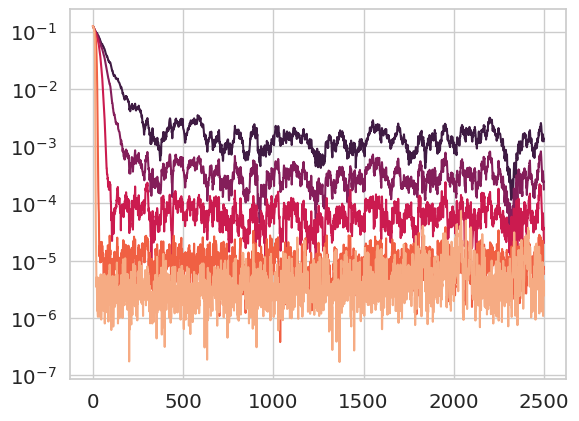

In [15]:
for i, loss in enumerate(all_losses):
    plt.semilogy(loss)
plt.show()

In [16]:
all_overlaps = []
for i, gamma in enumerate(gamma_vals):
    overlaps, c = solve_theory(gamma, beta, L)
    all_overlaps += [overlaps]

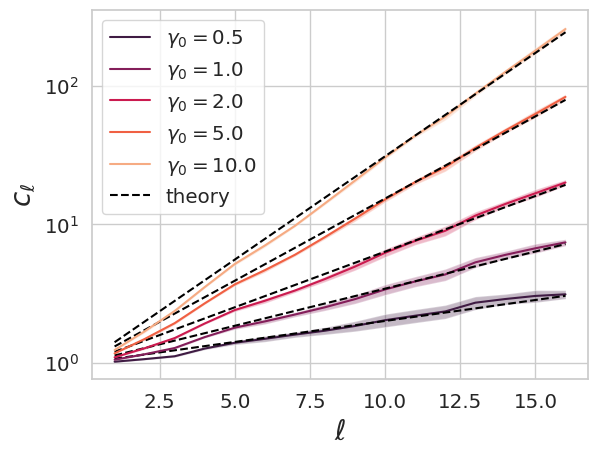

In [17]:
all_all_cs = jnp.array(all_all_cs)
for i, gamma in enumerate(gamma_vals):
    plt.semilogy( jnp.arange(1,L+1), all_all_cs[i].mean(axis=0) , label = r'$\gamma_0 = %0.1f$' % gamma)
    plt.fill_between(jnp.arange(1,L+1), all_all_cs[i].mean(axis=0) - all_all_cs[i].std(axis=0) , all_all_cs[i].mean(axis=0) + all_all_cs[i].std(axis=0) , alpha = 0.3)
    plt.semilogy( jnp.arange(1,L+1), all_overlaps[i] , '--', color = 'black')

plt.semilogy([],[], '--', color = 'black', label = 'theory')
plt.xlabel(r'$\ell$',fontsize = 20)
plt.ylabel(r'$c_{\ell}$',fontsize = 20)
plt.legend()
plt.savefig(f'c_ell_depth_{L}_vary_gamma.pdf',bbox_inches = 'tight')
plt.show()

In [18]:
Lvals = [1, 2, 4, 8, 16]
beta = 100.0
gamma_vals = jnp.logspace( -1.8, 2.0, 20 )
all_c = []

for i, L in enumerate(Lvals):
    all_c_i = []

    for j, gamma in enumerate(gamma_vals):
        overlaps, c = solve_theory(gamma, beta, L)
        print(c)
        all_c_i += [c]
    all_c += [all_c_i]

1.0002462
1.0006181
1.0015513
1.0038878
1.0097106
1.0240567
1.0584981
1.1369755
1.3012855
1.6125247
2.1549127
3.0531244
4.5035954
6.8201456
10.502992
16.347134
25.614044
40.303974
63.587807
100.491295
1.0004925
1.0012358
1.0031004
1.0077612
1.0193338
1.0476056
1.114332
1.2624271
1.5652905
2.140142
3.183239
5.0441628
8.359776
14.295538
24.987692
44.358135
79.617546
144.03955
262.08282
478.84778
1.0009847
1.0024704
1.0061913
1.0154665
1.0383308
1.0933393
1.2196536
1.4904802
2.0322862
3.0697005
5.028929
8.746597
15.885822
29.778225
57.14219
111.60534
220.9479
442.037
891.68994
1810.5612
1.0019684
1.0049354
1.0123467
1.0307133
1.075403
1.1802081
1.4119172
1.8913286
2.8382466
4.6798534
8.283714
15.445104
29.921967
59.658276
121.5938
252.1284
529.99475
1126.4644
2415.963
5220.5273
1.003933
1.0098469
1.0245525
1.0605979
1.1463516
1.3401406
1.750899
2.578577
4.212961
7.455044
13.991188
27.421259
55.518585
115.24084
243.91476
524.3516
1141.5312
2511.1296
5572.151
12455.566


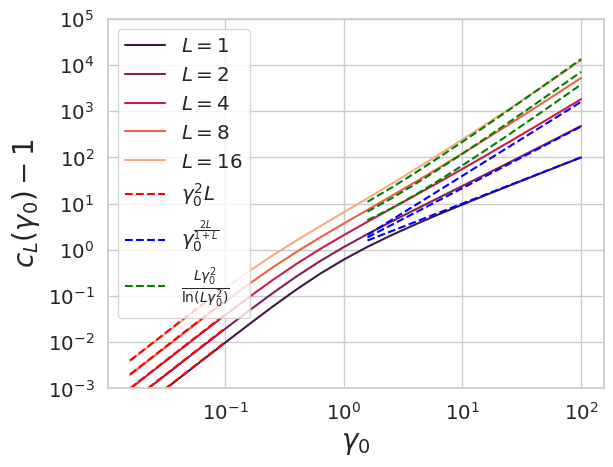

In [19]:
sns.set_palette("rocket", n_colors=len(Lvals))

for i, cs in enumerate(all_c):
    plt.loglog(gamma_vals, jnp.array(cs)-1.0, label = f'$L = {Lvals[i]}$')

    plt.loglog(gamma_vals[:5], Lvals[i] * jnp.array(gamma_vals[:5])**( 2 )  ,'--', color = 'red')

    if i <= 2:
        plt.loglog(gamma_vals[10:], jnp.array(gamma_vals[10:])**( 2*Lvals[i]/(Lvals[i]+1) ),'--', color = 'blue')

    if i > 1:
        plt.loglog(gamma_vals[10:], Lvals[i]*jnp.array(gamma_vals[10:])**( 2 ) / jnp.log( Lvals[i]*jnp.array(gamma_vals[10:])**( 2 ) ),'--', color = 'green')


plt.loglog([],[], '--', color = 'red', label = r'$\gamma_0^2 L$')
plt.loglog([],[], '--', color = 'blue', label = r'$\gamma_0^{ \frac{2L}{1+L}}$')
plt.loglog([],[], '--', color = 'green', label = r'$\frac{L \gamma_0^{2}}{\ln(L \gamma_0^2)}$')

plt.xlabel(r'$\gamma_0$',fontsize = 20)
plt.ylabel(r'$c_L(\gamma_0) - 1$',fontsize = 20)
plt.legend()
plt.ylim([1e-3, 1e5])
plt.savefig(f'c_L_vs_depth_gamma_asymptotics.pdf',bbox_inches = 'tight')
plt.show()

In [20]:
N = 1024
L = 8
eta = 0.0005
beta = 5.0
T = 2500
gamma = 4.0


Nvals = [512, 1024]

all_H = []
for i, N in enumerate(Nvals):
    train_losses, test_losses, H_avg, all_cs, params, Ws = deep_linear(X,y,N,L,T,eta,gamma,beta)
    all_H += [ H_avg ]

In [21]:
overlaps, c = solve_theory(gamma, beta, L)
H_th = [ jnp.eye(y.shape[0]) + (cl-1.0) * jnp.outer(y,y) for i, cl in enumerate(overlaps) ]

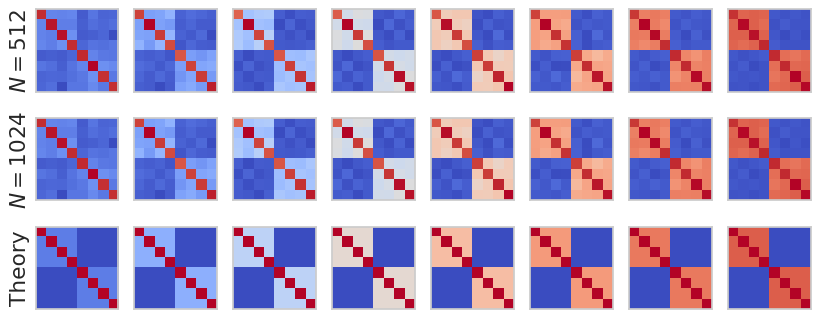

In [22]:
plt.figure(figsize = (10,4))

for j, Havg in enumerate(all_H):
      for i, H in enumerate(H_avg):
        plt.subplot(len(Nvals)+1, L, i+1 + j*L)
        plt.imshow( H , cmap = 'coolwarm')
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel(f'$N = {Nvals[j]}$')

for i in range(L):
    plt.subplot(len(Nvals)+1,L,L * len(Nvals) +i+1 )
    plt.imshow( H_th[i] , cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel(r'Theory')

plt.savefig(f'final_kernels_bayes_gamma_{gamma}_L_{L}.pdf',bbox_inches = 'tight')
plt.show()